In [551]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import sklearn.metrics as metrics
import torch.optim as optim
import  torchvision.datasets
import torchvision.models as models
import torchvision.transforms as tf
from torchvision.datasets import DatasetFolder, ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F


# %matplotlib inline


# VGG19
This is a barebone implementation of the VGG19 model based on the paper.

__note__ = Make sure to run the model before running the training set, in order to rest the model properly

In [552]:

def get_accuracy(model, data):
    '''
    @model: The model we are running training accuracy on.
    @data: A batch of images to check the accuracy
    @return: The probability of accuracy
    '''

    loader = torch.utils.data.DataLoader(data, batch_size=32)
    model.eval()
    correct = 0
    total = 0
    for imgs, labels in loader:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def train(model, train_data, batch_size=32, weight_decay=0.0,
          learning_rate=0.001, num_epochs=10, checkpoint_path=None,
          valid_data = None):
    '''
    @model: The MLP model we are training
    @batch_size: The batch size to use
    @weight_decay: The weight decay parameter for Adam optimizer
    @learning rate: The learning rate for the adam optimizer
    @nnum_epochs: The number of epochs to run
    '''

    # load the train data
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               shuffle=True)



    # defining loss function and optimizer, using ADAM
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),
                           lr=learning_rate,
                           weight_decay=weight_decay)

    # keeping track of training acc and val_acc
    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            model.train()

            # forward pass and backward pass
            out = model(imgs)
            loss = criterion(out, labels)
            loss.backward()
            optimizer.step()

            # zero the gradient parameter
            optimizer.zero_grad()
            n += 1

        # calculating loss and accuracy
        loss = float(loss)/batch_size
        tacc = get_accuracy(model, train_data)

        if (valid_data!= None):
            vacc = get_accuracy(model, valid_data)
            print("Iter %d; Loss %f; Train Acc %.3f; Val Acc %.3f" % (n, loss, tacc, vacc))
            val_acc.append(vacc)
        else:
            print("Iter %d; Loss %f; Train Acc %.3f;" % (n, loss, tacc))

        iters.append(n)
        losses.append(loss)
        train_acc.append(tacc)

        # creating checkpoint for saving the model
        if (checkpoint_path is not None) and epoch % 10 == 0:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))


    # plotting
    plt.title("Learning Curve")
    plt.plot(iters, losses, label="Train")

    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(iters, train_acc, label="Train")
    if (valid_data!=None):
        plt.plot(iters, val_acc, label="Test")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    PATH = './cifar_net.pth'+ model.name
    torch.save(model.state_dict(), PATH)

    print("Final Training Accuracy: {}".format(train_acc[-1]))


In [553]:
# function to show an image (taken from TUT09)
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.ion()
    plt.show()

def dataPreparation(path, batchsize, imagesize, pathTest, validTest = None):
    transform = tf.Compose([tf.Resize((imagesize,imagesize)),
                            # tf.RandomHorizontalFlip(),
                            tf.ToTensor(),
                            tf.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
    trainingdata= ImageFolder(root=path, transform=transform)
    testdata= ImageFolder(root=pathTest, transform=transform)
    trainloader = DataLoader(dataset=trainingdata, batch_size= batchsize, shuffle=True)
    classes_ = trainingdata.classes

    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # show images
    imshow(torchvision.utils.make_grid(images))

    validdata = None
    if (validTest != None):
        validdata= ImageFolder(root=validTest, transform=transform)

    # print labels
    print(' '.join('%5s' % classes_[labels[j]] for j in range(4)))

    return trainingdata, testdata, validdata

In [554]:
import torch
import torch.nn as nn

# creating a VGG19 model
class VGG19(nn.Module):
    def __init__(self, num_classes=2):
        super(VGG19, self).__init__()
        self.features = nn.Sequential(

            # First Layer of VGG19
            nn.Conv2d(3, 64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3,  stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            # Second layer of VGG19
            nn.Conv2d(64, 128, kernel_size=3,stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            # Third layer of VGG19
            nn.Conv2d(128, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            # Fourth layer of VGG19
            nn.Conv2d(256, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),

            #Fifth layer of VGG19
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# Running VGG19 model on Tumor data

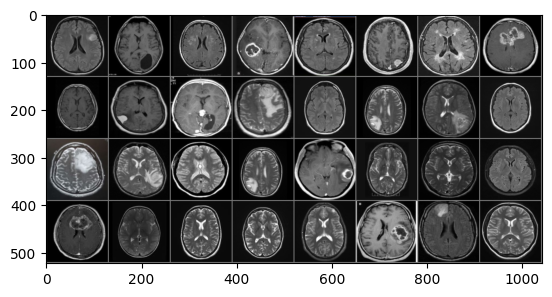

  yes    no    no   yes


Dataset ImageFolder
    Number of datapoints: 202
    Root location: ./data/tumor/train/
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [555]:
traindata, testdata, validdata = dataPreparation(path="./data/tumor/train/", batchsize=32,imagesize=128, pathTest="./data/tumor/test/")
traindata

In [556]:
VGG19 = VGG19(2)

In [ ]:

train(VGG19, traindata, batch_size=32, num_epochs=20, valid_data=testdata)

Iter 7; Loss 0.037488; Train Acc 0.614; Val Acc 0.620
Iter 14; Loss 0.021912; Train Acc 0.614; Val Acc 0.620


# Test the network

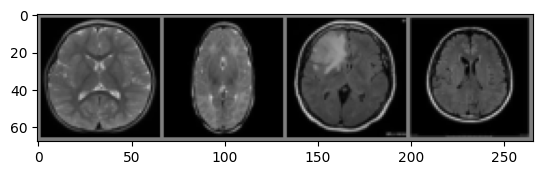

GroundTruth:     no    no   yes    no
Predicted:     no    no    no    no
Accuracy of the network on the 50 test images: 38 %


In [498]:
def TestModel(net, testdata):
    # display images from test set
    classes = testdata.classes
    test_loader = torch.utils.data.DataLoader(testdata,
                                              batch_size=4,
                                              shuffle=True)
    dataiter = iter(test_loader)
    images, labels = next(dataiter)


    imshow(torchvision.utils.make_grid(images))
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))


    # object categories predicted by the network
    outputs = net(images)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                                  for j in range(4)))

    # accuracy on the full test data set (10,000 images)
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 50 test images: %d %%' % (
            100 * correct / total))
TestModel(VGG19, testdata)

# Running VGG19 on asl dataset

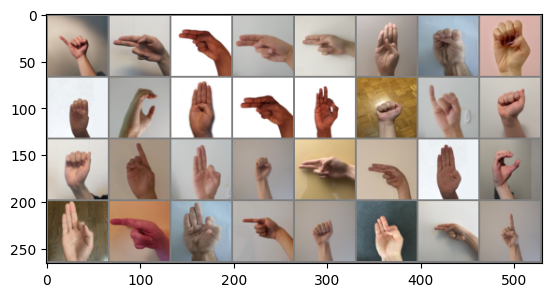

    I     H     H     H


Dataset ImageFolder
    Number of datapoints: 733
    Root location: ./data/asl_data/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [544]:
traindata, testdata, validdata = dataPreparation(path="./data/asl_data/train/", batchsize=32,imagesize=64, pathTest="./data/asl_data/test/", validTest="./data/asl_data/valid/")
traindata

Iter 23; Loss 0.068895; Train Acc 0.112; Val Acc 0.121
Iter 46; Loss 0.069057; Train Acc 0.121; Val Acc 0.121
Iter 69; Loss 0.068538; Train Acc 0.112; Val Acc 0.111
Iter 92; Loss 0.068523; Train Acc 0.117; Val Acc 0.116
Iter 115; Loss 0.068818; Train Acc 0.121; Val Acc 0.121
Iter 138; Loss 0.069002; Train Acc 0.121; Val Acc 0.121
Iter 161; Loss 0.068529; Train Acc 0.121; Val Acc 0.121
Iter 184; Loss 0.069152; Train Acc 0.121; Val Acc 0.121
Iter 207; Loss 0.068995; Train Acc 0.121; Val Acc 0.121
Iter 230; Loss 0.069216; Train Acc 0.121; Val Acc 0.121


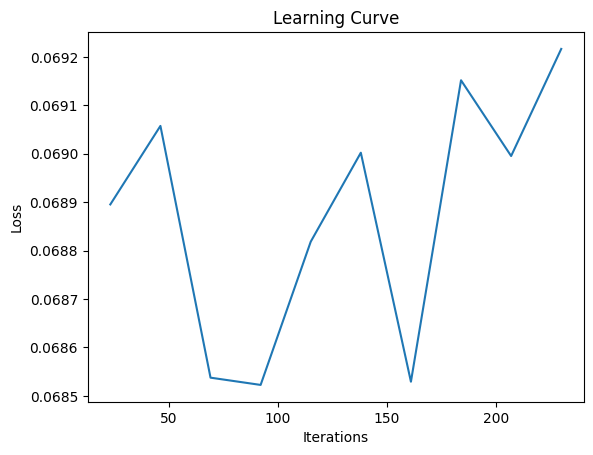

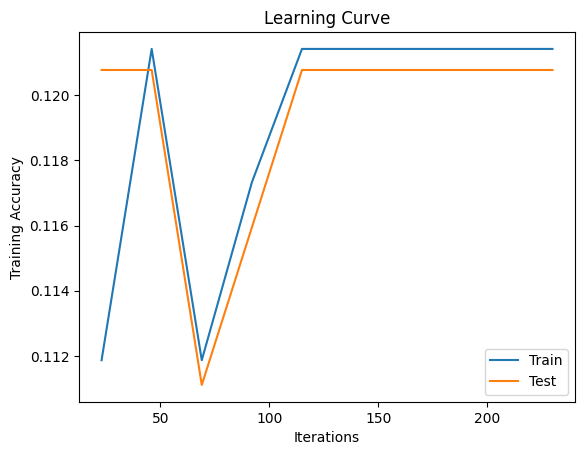

AttributeError: 'VGG19' object has no attribute 'name'

In [545]:
VGG19 = VGG19(9)
train(VGG19, traindata, batch_size=32, num_epochs=10, valid_data=validdata)

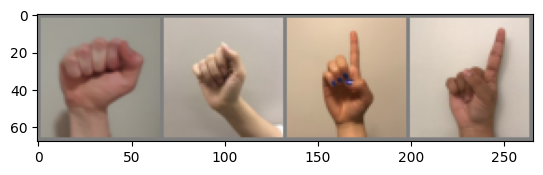

GroundTruth:      A     A     D     D
Predicted:      I     I     I     I
Accuracy of the network on the 50 test images: 12 %


In [546]:
TestModel(VGG19, testdata)